# Coefficients and Stats

In [285]:
from pprint import pprint
from glob import glob
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.naive_bayes import MultinomialNB

from sklearn.svm import SVC
from PIL import Image
import wordcloud
import time
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [175]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [176]:
!pwd

/Users/chris/github/reddit_nlp/util


In [177]:
from util import databases
from util import dataloader
from util import grid_models
from util.reddit_functions import Reddit, Visualizer, Labeler

In [178]:
!pwd

/Users/chris/github/reddit_nlp/util


In [266]:
# list to get data for
subreddit_list = ['datascience','machinelearning','dataengineering','python','aws']

# load data using dataloader module
df = dataloader.data_selector(subreddit_list, source='sqlite')

# what we expected?
for sub in subreddit_list:
    print(sub, len(df[df['subreddit'] == sub]))

df.info()
df.sample(10)

Connection to SQLite DB successful
datascience 4402
machinelearning 4967
dataengineering 4883
python 4657
aws 4986
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23895 entries, 0 to 23894
Data columns (total 3 columns):
title        23895 non-null object
subreddit    23895 non-null object
date         23895 non-null object
dtypes: object(3)
memory usage: 560.2+ KB


,title,subreddit,date
3887,Big Data Analytics with PySpark + Tableau Desk...,dataengineering,2020-03-29
18820,Moving csv from S3 to RDS MySQL using Airflow?,dataengineering,2020-04-14
19948,Question about CloudFront,aws,2020-04-20
8312,Deploy project on heroku,python,2020-04-02
5627,DirectConnect Plus VPN,aws,2020-04-02
9383,Data Engineer vs. Senior Data Warehouse Engineer,dataengineering,2020-04-02
2917,Asynchronous programming. Blocking I/O and non...,python,2020-03-29
11235,Can Data Scientists become an entrepreneur?,datascience,2020-04-10
18733,Spark Streaming?,dataengineering,2020-04-14
4761,An interview about the Pilosa bitmap index ser...,dataengineering,2020-03-29


In [293]:
X = df['title']
y = df['subreddit']

In [294]:
labeler = Labeler()
labeler.fit(y)
y = labeler.transform(y)
classes = labeler.classes_
labeler.encodings_

{'aws': 0,
 'datascience': 1,
 'machinelearning': 2,
 'python': 3,
 'dataengineering': 4}

In [279]:
useless_words = set(['using', 'lambda', 's3', 'does', 'looking', 'help', 'new', 'data', 'science', 'machine', 'learning', 'use', 'need', 'engineer', 'engineering'])

custom_stop_words = ENGLISH_STOP_WORDS.union(subreddit_list, useless_words)

In [280]:
tfidf = TfidfVectorizer(max_df=0.7, max_features=6000, ngram_range=(1,2), stop_words=custom_stop_words)
logreg = LogisticRegression(max_iter=1000)
pipe = Pipeline([('tfidf', tfidf),('logreg', logreg)])

In [281]:
model = pipe.fit(X, y)

In [282]:
model.score(X, y)

0.9294413057124922

In [288]:
# make sure to cross_val on X and y, not X_train and y_train or data will be split twice
cross_val_score(model, X, y, cv=StratifiedKFold(shuffle=True))

array([0.85729232, 0.86608077, 0.85645533, 0.86838251, 0.86524377])

# Coefficients

In [218]:
# only works for linear models with coefficients
coef_dict = {}
for i, sub in enumerate(classes):
    coef_dict[sub] = pd.DataFrame(
                        data=model.named_steps.logreg.coef_[i],
                        index=model.named_steps.tfidf.get_feature_names()
                        )

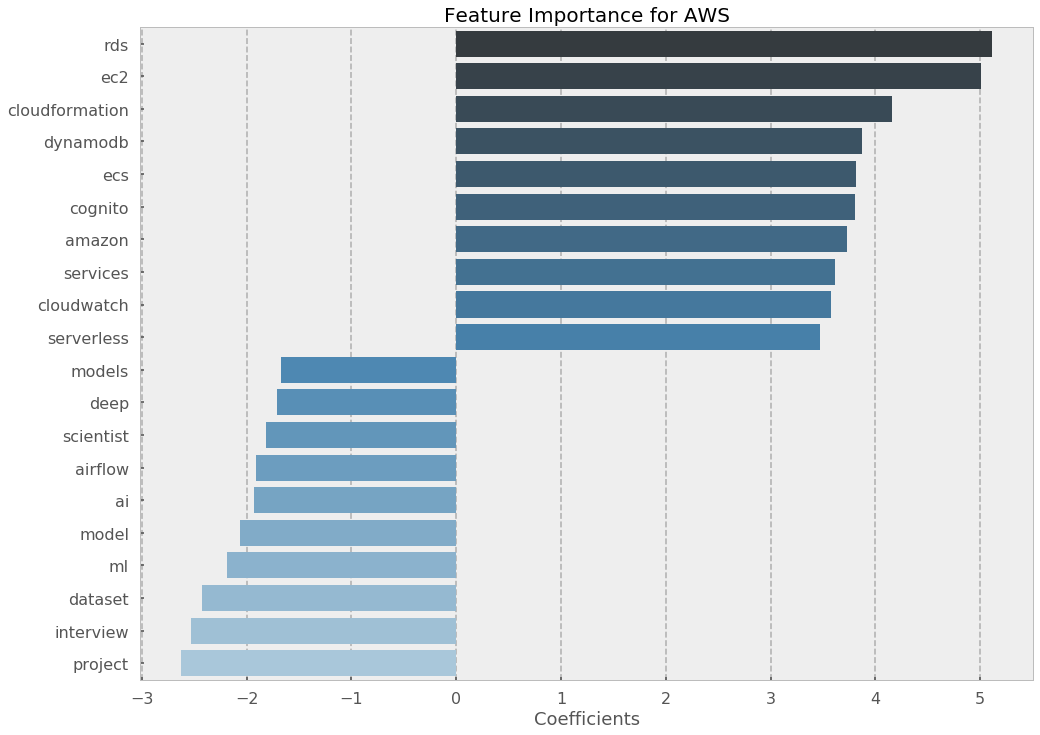

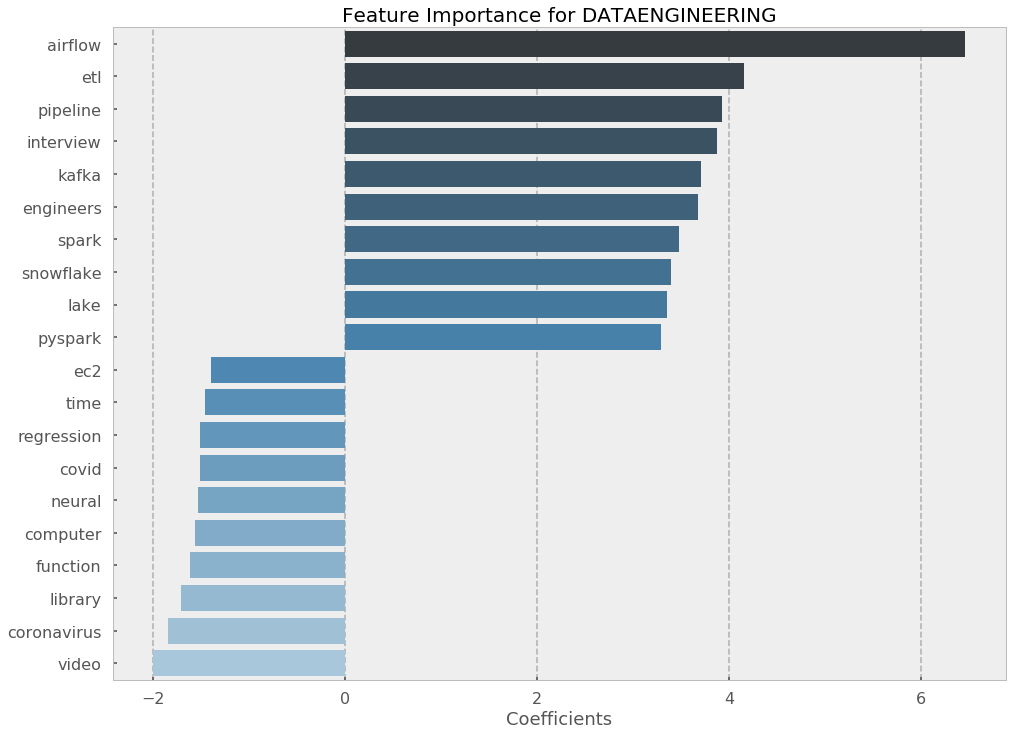

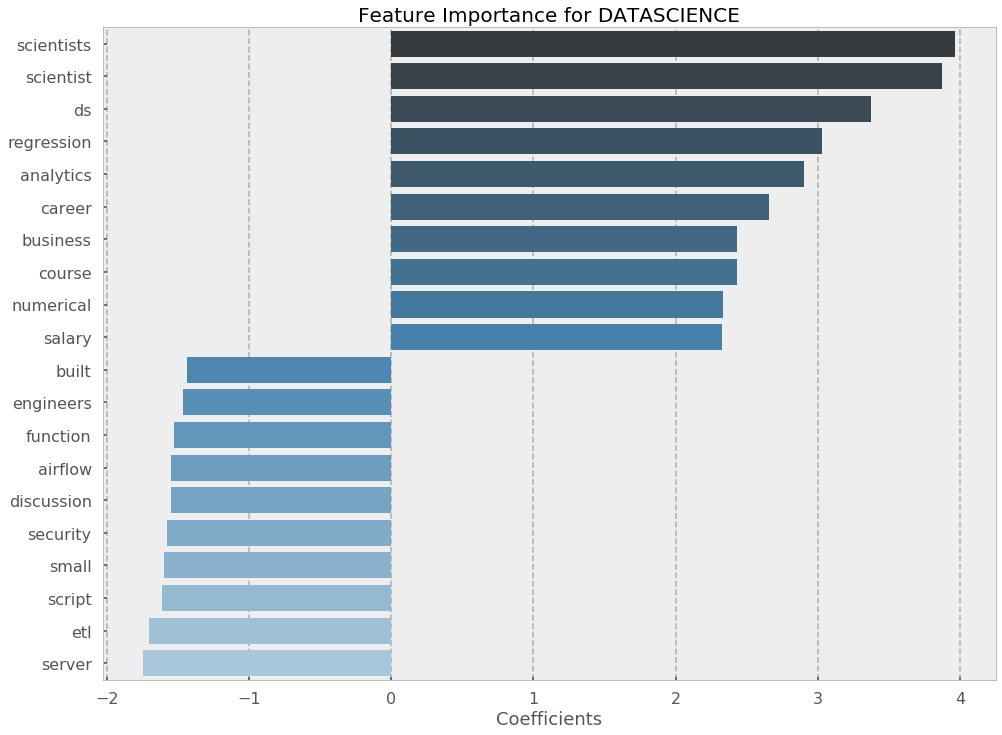

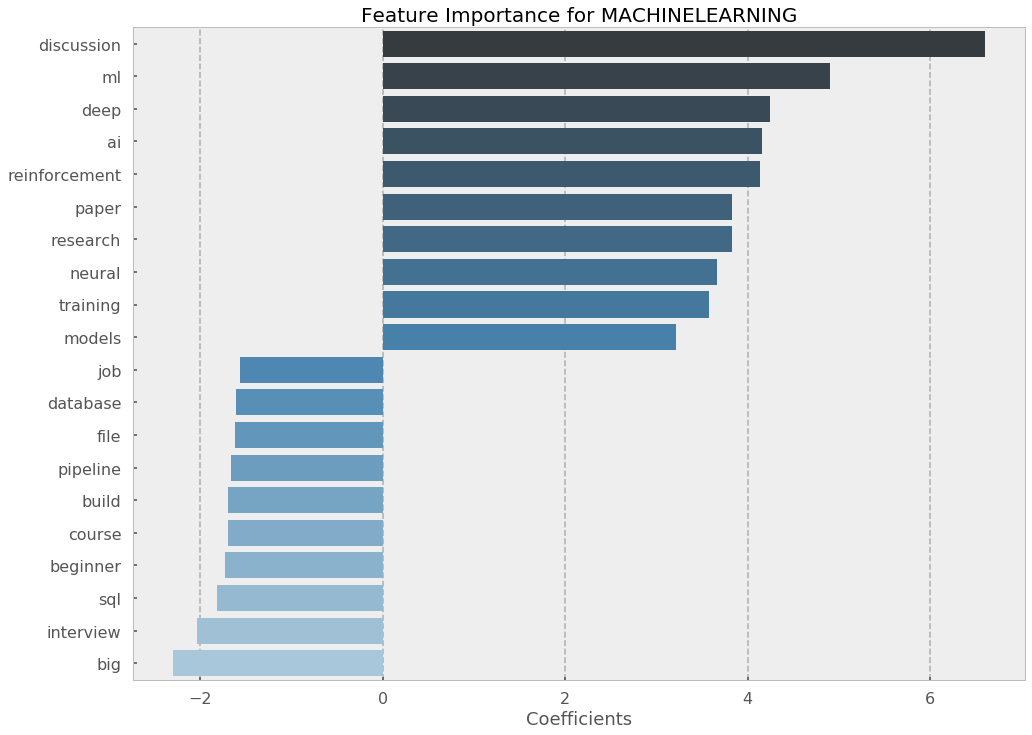

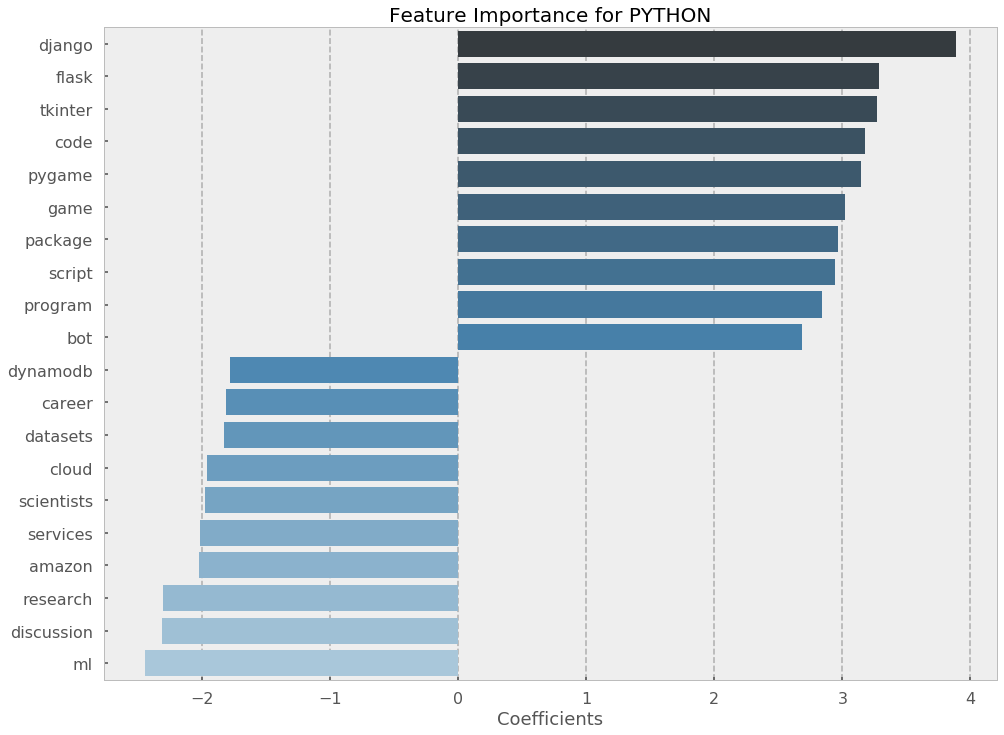

In [217]:
for sub, df in coef_dict.items():

    plt.figure(figsize=(16, 12))
    plt.style.use('seaborn-poster')

    top_10 = df.sort_values(0, ascending=False)[0].head(10)
    bottom_10 = df.sort_values(0, ascending=False)[0].tail(10)
    top_and_bottom = pd.DataFrame(data=top_10.append(bottom_10))
    sns.barplot(x=top_and_bottom[0], y=top_and_bottom.index, palette='Blues_d');

    plt.title(f'Feature Importance for {sub.upper()}', fontsize=20)
    plt.xlabel('Coefficients', fontsize=18)

# Predictions

In [296]:
y_pred = model.predict(X_test)

In [297]:
df_cm = pd.DataFrame(data=confusion_matrix(y_test, y_pred),
                     columns=classes, index=classes)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
df_cm

Predicted,aws,datascience,machinelearning,python,dataengineering
Actual,,,,,
aws,1149,6,2,38,17
datascience,2,996,18,24,28
machinelearning,4,24,1204,23,3
python,24,50,28,1056,29
dataengineering,8,33,5,36,1167


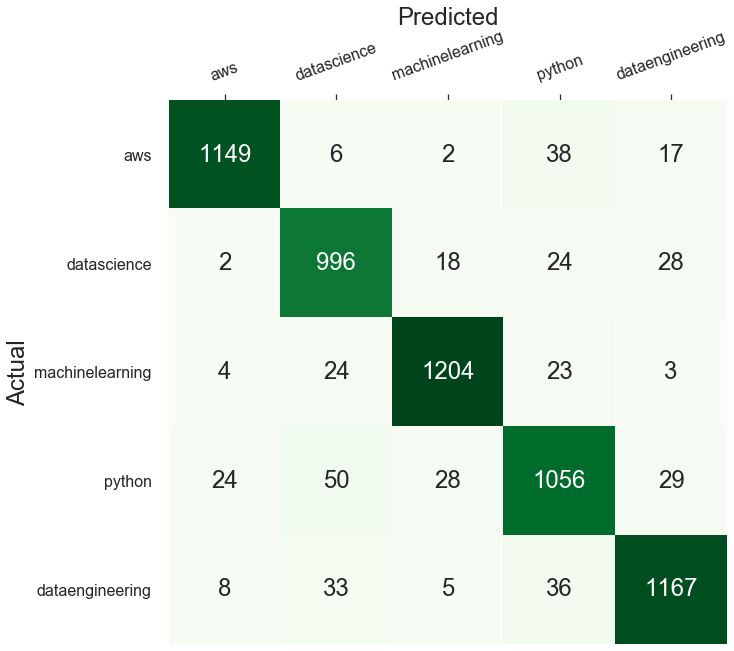

In [298]:
fig, ax = plt.subplots(figsize=(2*len(classes),2*len(classes)))

sns.set(font_scale=2)
sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, cmap='Greens', ax=ax)
fontdict={'fontsize': 16}

ax.set_yticklabels(labels=classes, rotation='horizontal', fontdict=fontdict)
ax.set_xticklabels(labels=classes, rotation=20, fontdict=fontdict)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

In [299]:
mcm = multilabel_confusion_matrix(y_test, y_pred)
mtn = mcm[:, 0, 0]
mtp = mcm[:, 1, 1]
mfn = mcm[:, 1, 0]
mfp = mcm[:, 0, 1]
print(mcm)

[[[4724   38]
  [  63 1149]]

 [[4793  113]
  [  72  996]]

 [[4663   53]
  [  54 1204]]

 [[4666  121]
  [ 131 1056]]

 [[4648   77]
  [  82 1167]]]


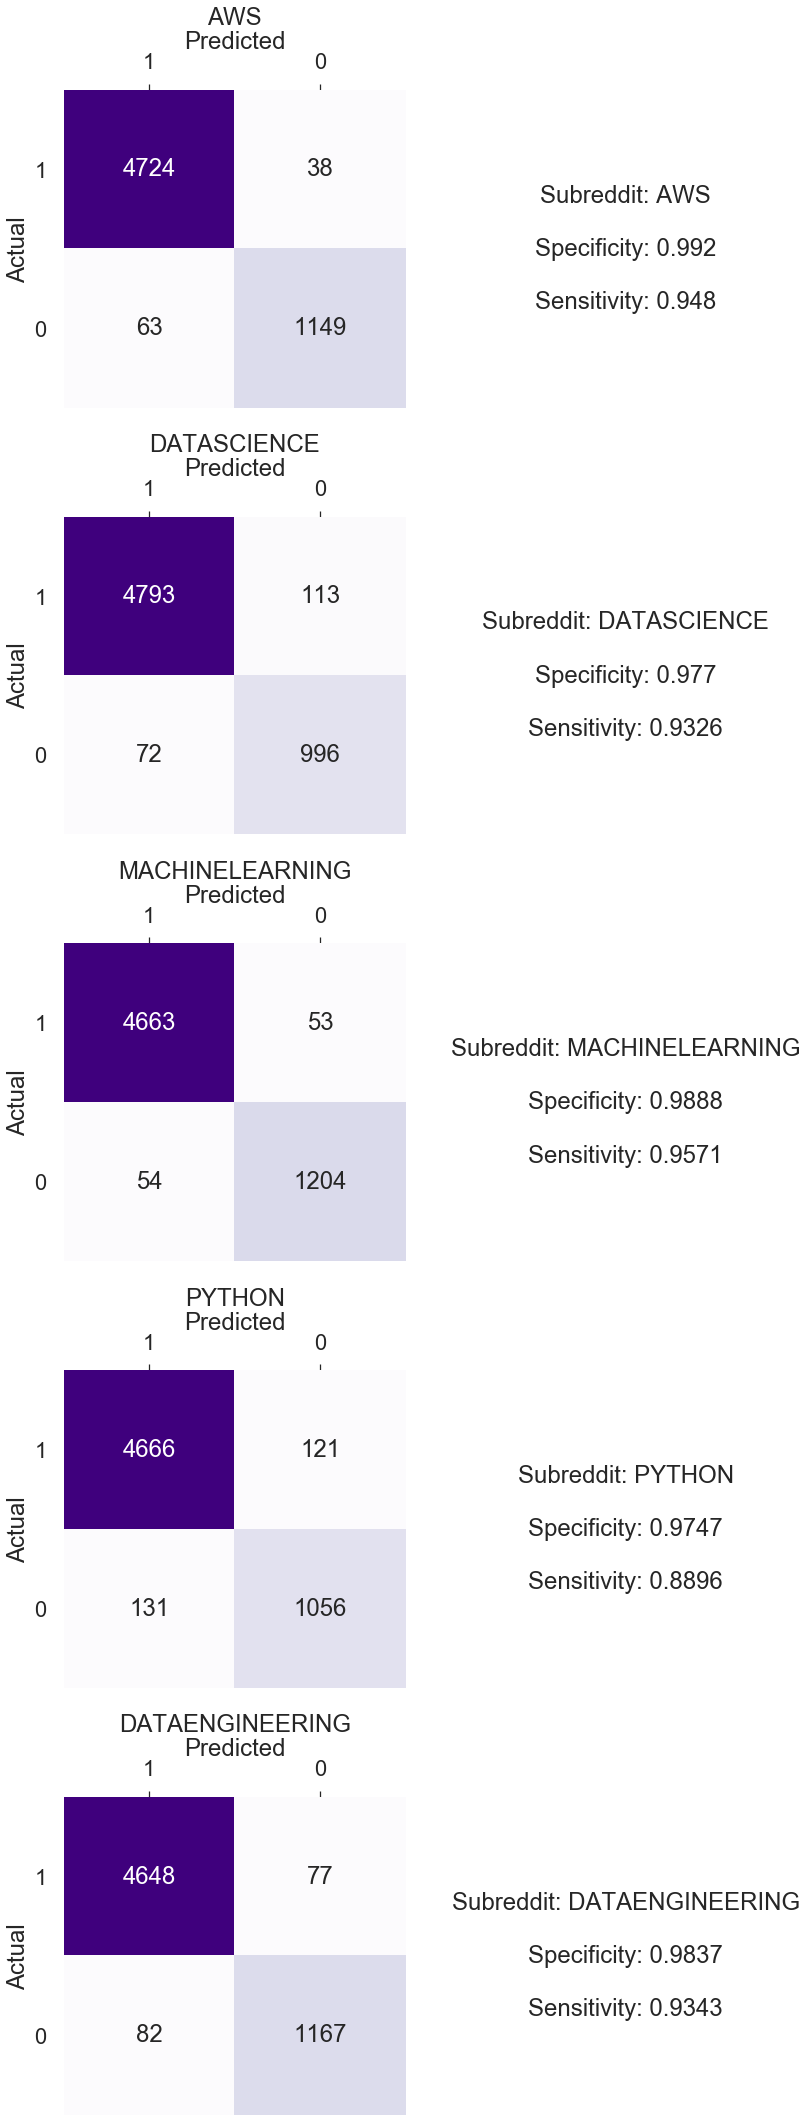

In [300]:
fig, ax = plt.subplots(ncols=2, nrows=len(labeler.classes_),
                       figsize=(12, 6*len(labeler.classes_)))

for i, cm in enumerate(mcm):
    df_cm = pd.DataFrame(cm)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    sns.heatmap(df_cm, annot=True, fmt="d", cbar=False,
                cmap='Purples', ax=ax[i, 0])

    ax[i, 0].set_yticklabels(labels=[1, 0], rotation='horizontal')
    ax[i, 0].set_xticklabels(labels=[1, 0])
    ax[i, 0].xaxis.tick_top()
    ax[i, 0].xaxis.set_label_position('top')
    ax[i, 0].set_title(labeler.classes_[i].upper())

    tn, fp, fn, tp = cm.ravel()
    specif = tn / (tn + fp)

    sens = tp / (tp + fn)
    box_text = f'''Subreddit: {labeler.classes_[i].upper()}\n\nSpecificity: {round(specif,4)}\n\nSensitivity: {round(sens,4)}'''
    ax[i, 1].text(0.5, 0.5, box_text, horizontalalignment='center',
                  verticalalignment='center', fontsize=24)
    ax[i, 1].set_axis_off()


plt.tight_layout()

In [261]:
print(classification_report(y_test, y_pred, digits=3, target_names=subreddit_list))

                 precision    recall  f1-score   support

    datascience      0.908     0.901     0.905      1212
machinelearning      0.818     0.806     0.812      1068
dataengineering      0.883     0.915     0.899      1258
         python      0.807     0.792     0.799      1187
            aws      0.867     0.868     0.867      1249

       accuracy                          0.858      5974
      macro avg      0.857     0.856     0.856      5974
   weighted avg      0.858     0.858     0.858      5974



<h1>TODO:</h1>

1. Make it have the roc for each sub, have to get into the original df where subname equals indexes?

In [262]:
y_test.index

Int64Index([22518, 17905, 14153, 14423, 17017,  1100, 21700,  9409, 11683,
             5299,
            ...
            17806, 21427, 19079, 12544, 22556, 22237, 11263,  4070,  4053,
            10927],
           dtype='int64', length=5974)

In [ ]:
auc = roc_auc_score(y_test, y_pred)
auc

In [ ]:
probs = model.predict_proba(X_test)[:,1]

In [ ]:
# not multiclass
fpr, tpr, thresholds = roc_curve(y_test, probs)

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc})', color='r', marker='D')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)', size=16)
plt.ylabel('True Positive Rate (Sensitivity)', size=16)
plt.title('ROC Curve', size=20)
plt.legend(fontsize=14);

In [ ]:
x1 = np.random.normal(0, 0.8, 1000) x2 = np.random.normal(-2, 1, 1000) x3 = np.random.normal(3, 2, 1000)
kwargs = dict(histtype='stepfilled', alpha=0.3, normed=True, bins=40)
plt.hist(x1, **kwargs) plt.hist(x2, **kwargs) plt.hist(x3, **kwargs);

In [ ]:
# Create figure.
plt.figure(figsize = (10,7))

# Create histogram of observations.
plt.hist(probs, bins=25, color='b')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18);

In [ ]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
hst0 = plt.hist(probs[y_test == 0],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Technology',)

hst1 = plt.hist(probs[y_test == 1],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Science')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
           ymin = 0,
           ymax = max(hst1[0].max(), hst0[0].max()), # Max of the two highest respective hist values
           color='r',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Science)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

# Thanks to Matt Brems for the colorful graphs! :)